# COVID-19 Disruptors, BIDS

## Load the libraries

In [166]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import Image
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
import pubchempy as pcp

#Needed to show molecules
from rdkit.Chem.Draw import IPythonConsole 

from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

# Download this from http://pypi.python.org/pypi/futures
# for parallel jobs (especially for mordred large molecular dataset)
from concurrent import futures

### Let us display some key inhibitors:

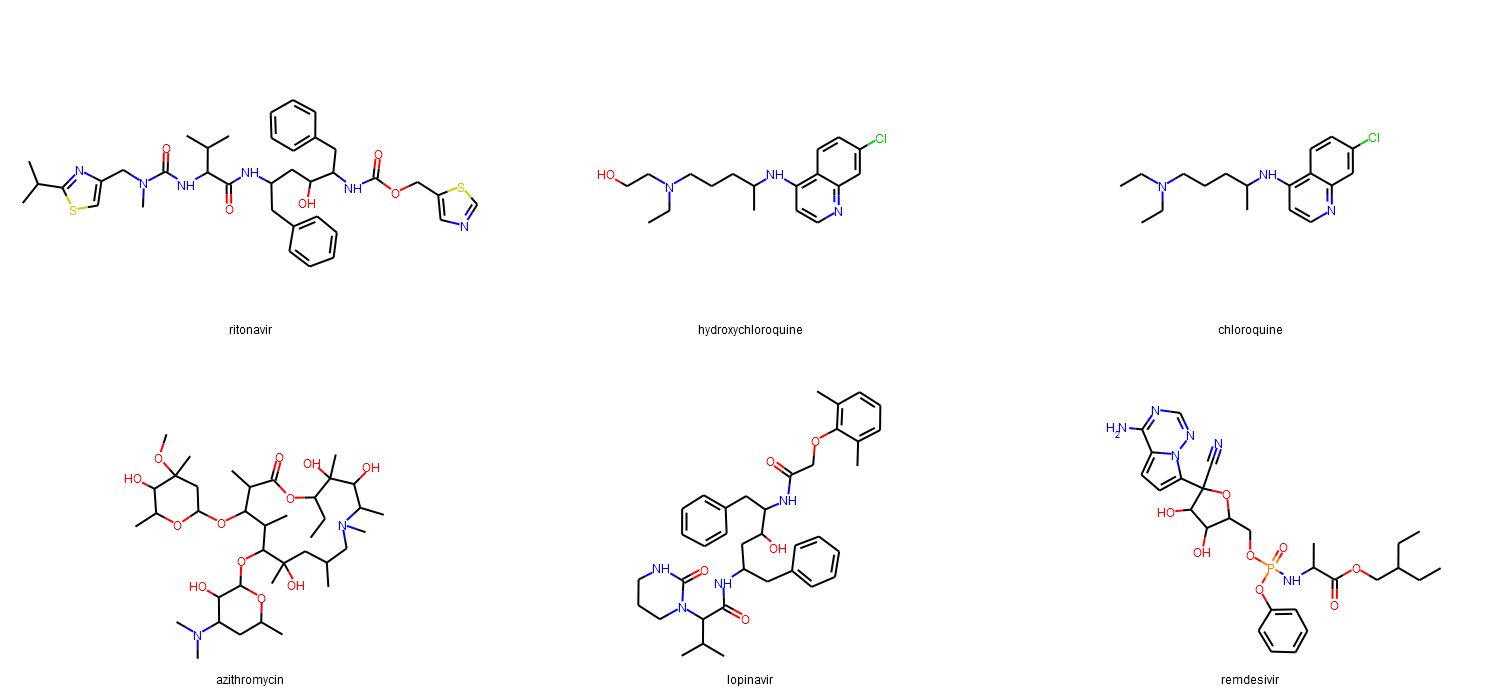

In [175]:
ritonavir = 'CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
hydroxychloroquine = 'CCN(CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl)CCO'
chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
azithromycin = 'CCC1C(C(C(N(CC(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(O2)C)O)(C)OC)C)OC3C(C(CC(O3)C)N(C)C)O)(C)O)C)C)C)O)(C)O'
lopinavir = 'CC1=C(C(=CC=C1)C)OCC(=O)NC(CC2=CC=CC=C2)C(CC(CC3=CC=CC=C3)NC(=O)C(C(C)C)N4CCCNC4=O)O'
remdesivir = 'CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4'

mols = [ ritonavir, hydroxychloroquine, chloroquine, azithromycin, lopinavir, remdesivir]
names = ['ritonavir', 'hydroxychloroquine', 'chloroquine', 'azithromycin', 'lopinavir', 'remdesivir']

mols = [Chem.MolFromSmiles(smi) for smi in mols]
for m in mols: tmp=AllChem.Compute2DCoords(m)

Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize=(500, 350), legends = names)

## Let us view the The crystal structure of COVID-19 main protease in complex with carmofur

In [176]:
# http://3dmol.csb.pitt.edu/doc/tutorial-url.html
import py3Dmol
p = py3Dmol.view(query='mmtf:7buy')
p.setStyle({'cartoon': {'color':'spectrum'}})

view = py3Dmol.view(query='pdb:7buy')
chA = {'chain':'A'}
chB = {'resn':'JRY'}
view.setStyle(chA,{'cartoon': {'color':'spectrum'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.9,'color':'red'}, chB)
view.setStyle(chB,{'sphere':{}})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Homology model of M-Pro

In [199]:
# http://3dmol.csb.pitt.edu/doc/tutorial-url.html
import py3Dmol
pdbdata=open('Data/QHD43415_5.pdb', 'r').read()
view=py3Dmol.view()
view.addModel(pdbdata,'pdb')
view.zoomTo()
view.setBackgroundColor('white')
view.setStyle({'cartoon': {'color':'spectrum'}})
# view.addSurface(py3Dmol.VDW,{'opacity':0.9,'color':'red'})
# view.addSurface(py3Dmol.SAS,{'opacity':1,'colorscheme':{'prop':'b','gradient':'rwb','min':-cut,'max':cut}})
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Let us read our custom compound library PubChem CIDs

In [177]:
cpds = pd.read_csv("MoleculesList.csv", encoding='iso-8859-1')
cid_list = cpds['PubChem'].to_list()
#cpds['Name'].tolist()
# len(cpds.PubChem)
# len(cpds.Name)

In [178]:
# cid_list.dtype(int)
# cid_list
# type(cid_list)

## Convert the CIDs into SMILES string

In [181]:
pcp.get_substances([1, 2, 3, 4], as_dataframe=True)
cs = pcp.get_compounds(cid_list)
df4 = pcp.compounds_to_frame(cs, properties=['isomeric_smiles','xlogp', 'rotatable_bond_count'])
# df4    
# df4.dtypes

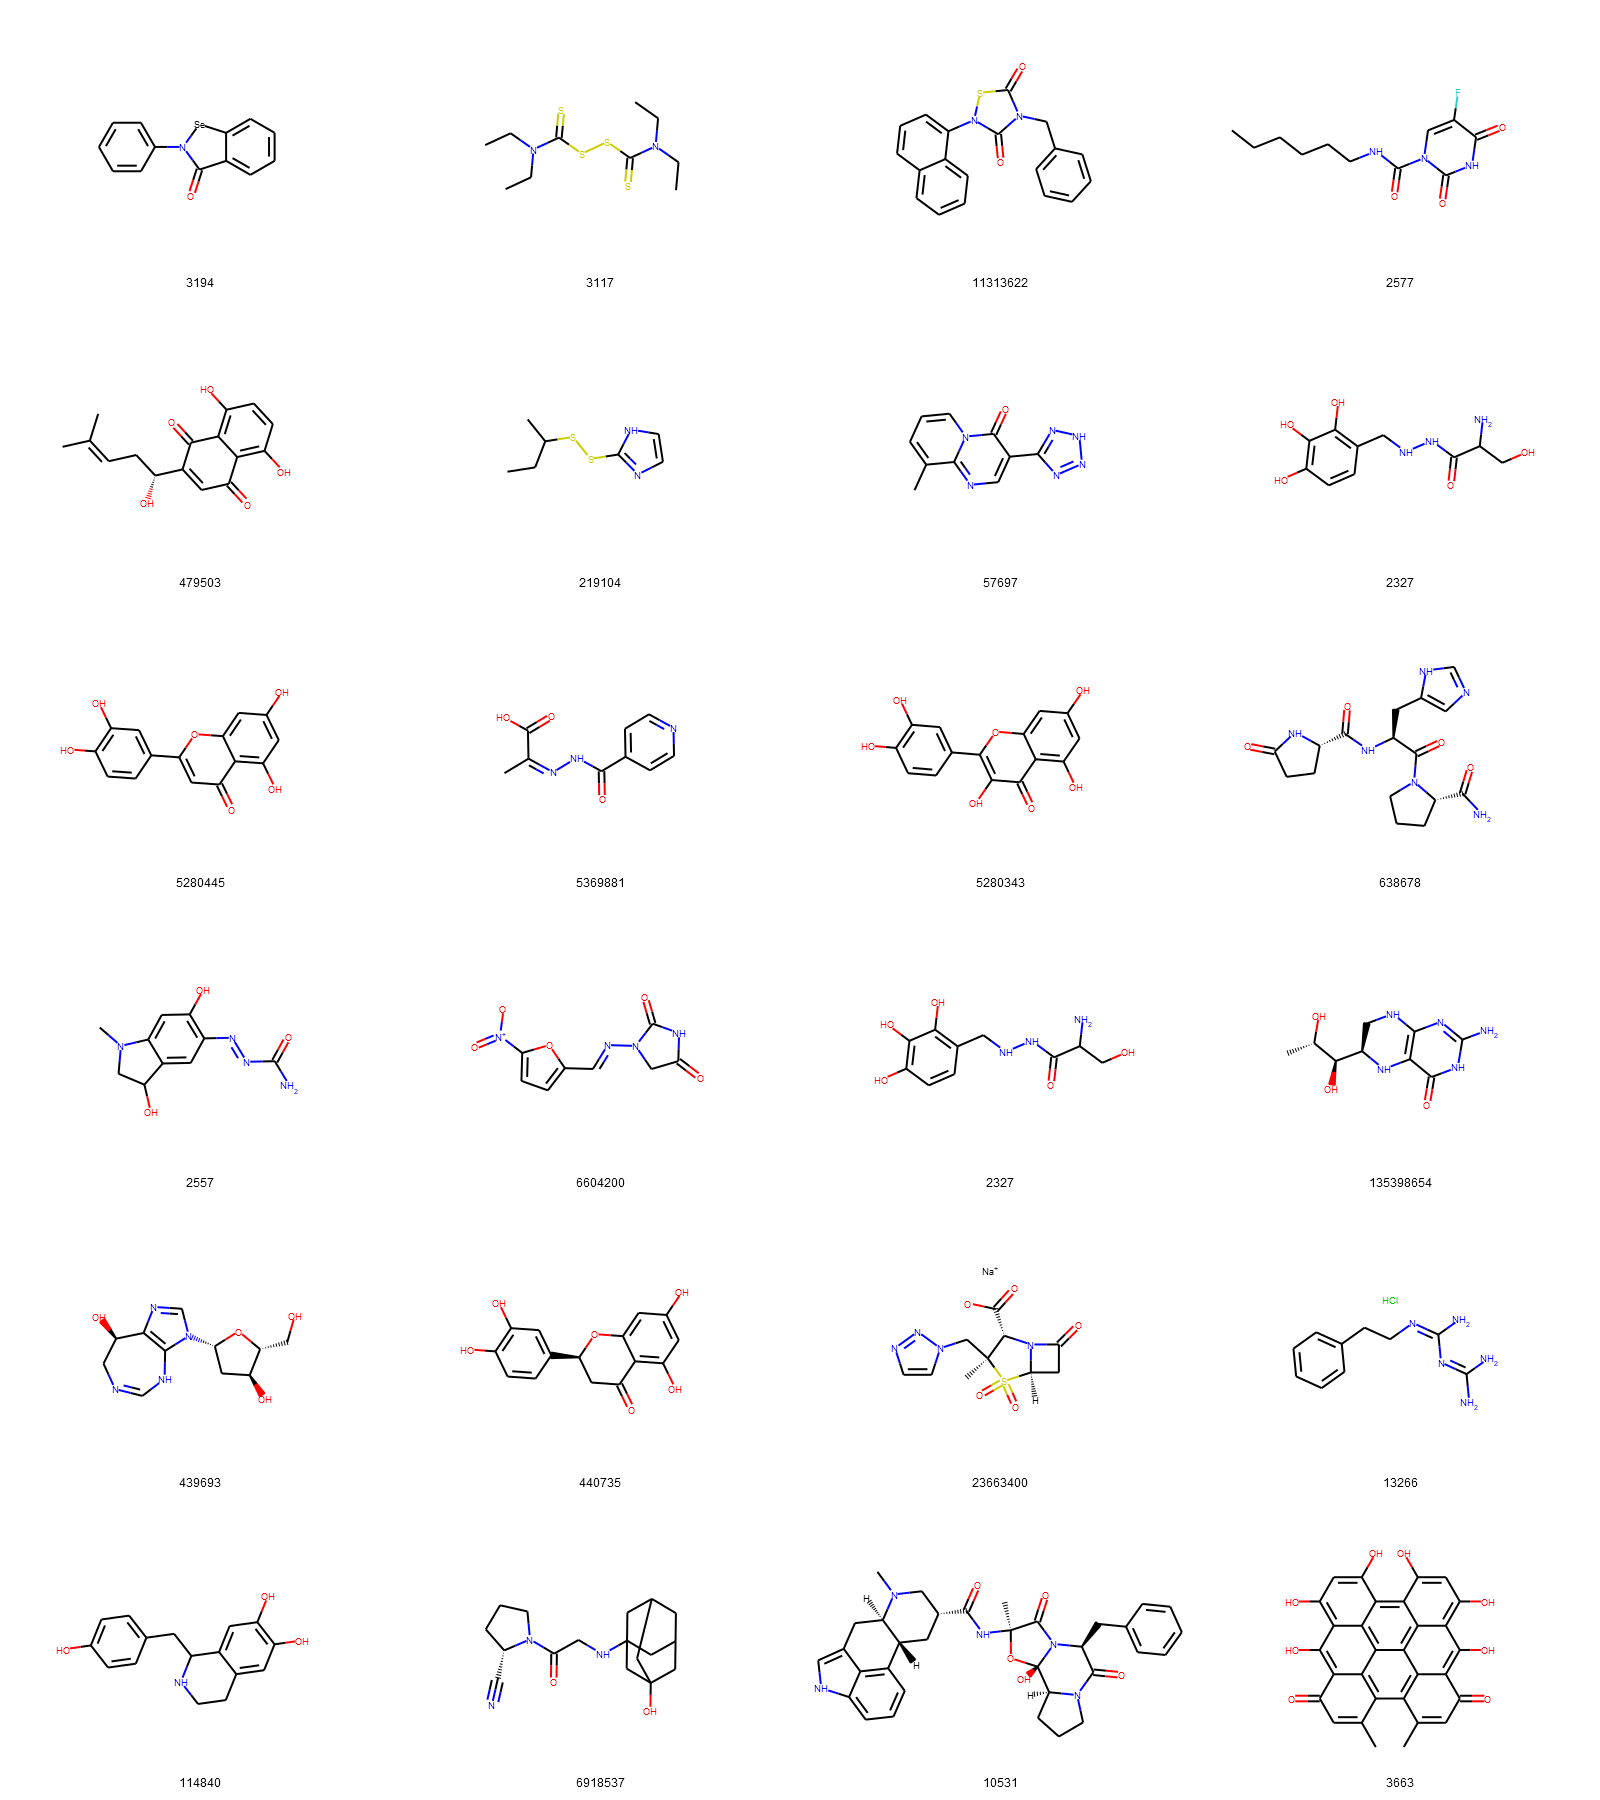

In [190]:
# show the molecules 
core = Chem.MolFromSmiles( 'C1=CC=CC2=C1C=CC=C2' ) 

#amide
core1 = Chem.MolFromSmiles( 'C(N[H])=O' ) 

csm_list = df4.index.values.astype('str').tolist()

csm = [Chem.MolFromSmiles(x) for x in df4.isomeric_smiles.to_list()]
Draw.MolsToGridImage( csm[:24], molsPerRow = 4, subImgSize=(400, 300),legends = csm_list[:24])

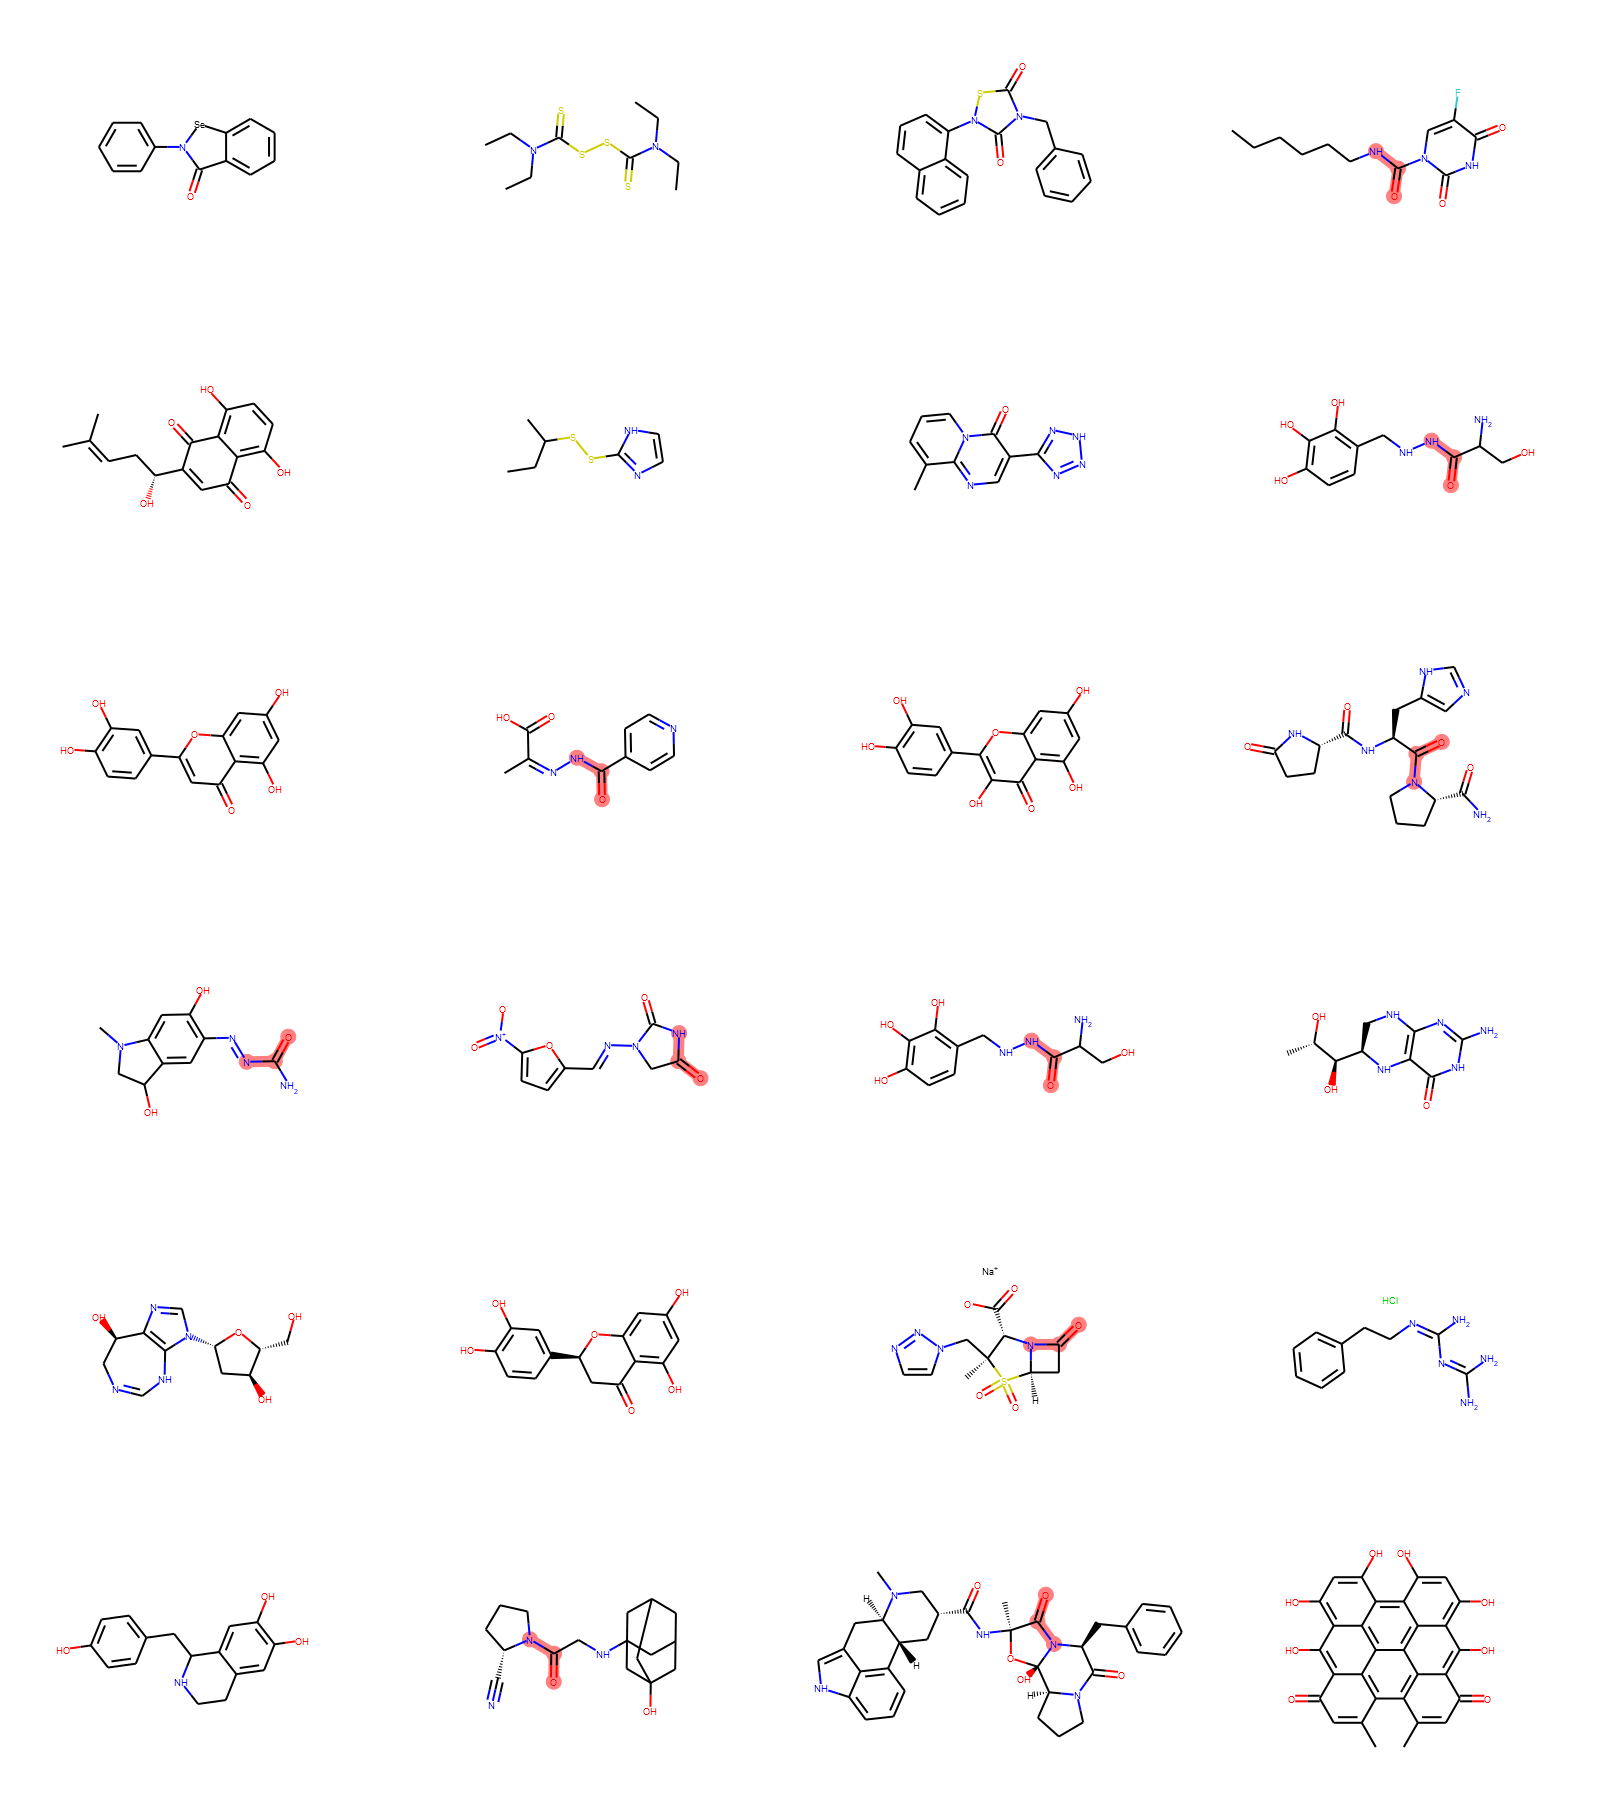

In [191]:
# highlightAtomLists is list of atom list that you want to highlight.
Draw.MolsToGridImage( csm[:24], molsPerRow=4, subImgSize=(400, 300), highlightAtomLists=[mol.GetSubstructMatch(core1) for mol in csm[:24]] )

## Generating molecular properties

For this section, we will be using cdkit and Mordred (a molecular descriptor calculator) to generate molecular descriptors. Follow the links shown below for information on mordred calculator:

* https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y
* https://github.com/mordred-descriptor/mordred


We will be using a python package called  mordred for generating descriptors. Mordred Github Page: https://github.com/mordred-descriptor/mordred and click here to see the complete list of mordred descriptors,
https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [187]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

In [189]:
# as pandas
df = calc.pandas(csm[:10])
df

100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0  12.675551  10.691629      0      0  21.747296  2.467683  4.743462   
1  10.744501  11.044544      0      0  18.877841  2.210509  4.421017   
2  19.068022  15.051707      0      0  32.397006  2.491733  4.903222   
3  13.044161  11.533290      0      0  21.826167  2.359082  4.718164   
4  16.038997  13.969917      0      0  25.921183  2.503405  5.006810   
5   7.887564   7.802399      0      0  13.855917  2.187113  4.255178   
6  13.451608  11.497362      2      0  22.492647  2.457867  4.902998   
7  13.113111  11.885521      0      1  22.203716  2.342088  4.684176   
8  16.608204  13.330263      0      0  26.321008  2.467430  4.934859   
9  10.963281  10.033994      1      0  18.556154  2.239094  4.478187   

      SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0  21.747296  1.359206  3.731392  ...   9.730740  63.051623  274.984935   
1  18.877841  1.179865  3.607722  ...   9.049115  46.690407  296.050933   
2  32.397006  1.349875  4.129666  ...  10.172178  73.120412  334.077599   
3  21.826167  1.212565  3.764897  ...   9.466300  50.095860  257.117570   
4  25.921183  1.234342  3.959040  ...  10.079749  55.097693  288.099774   
5  13.855917  1.259629  3.281381  ...   8.507749  52.785955  188.044190   
6  22.492647  1.323097  3.789440  ...   9.879144  63.377796  228.075959   
7  22.203716  1.233540  3.770033  ...   9.543020  50.345912  257.101171   
8  26.321008  1.253381  3.987292  ...  10.124509  55.372829  286.047738   
9  18.556154  1.237077  3.585883  ...   9.123802  45.923073  207.064391   

         AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
0  10.999397    415    24     86.0    103.0  4.055556  3.527778  
1   8.223637    502    21     66.0     72.0  7.944444  4.138889  
2   8.791516   1320    39    130.0    156.0  6.388889  5.250000  
3   7.562281    708    24     82.0     91.0  7.555556  4.250000  
4   7.786480    894    36    108.0    128.0  9.250000  4.611111  
5   8.175834    177     9     48.0     51.0  3.972222  2.666667  
6   9.123038    483    27     92.0    111.0  4.916667  3.722222  
7   7.790945    693    26     84.0     95.0  8.166667  4.194444  
8   9.227346    896    36    114.0    136.0  7.750000  4.472222  
9   8.627683    414    18     68.0     74.0  6.194444  3.472222  

[10 rows x 1613 columns]

**Please inspect the descriptor table before you use them in other calculations. Especially when you are generating all the descriptors, some of the columns may contain NA or Nan etc.**

## Supporting pages:

* [RDKIT:](https://rdkit.org/docs/GettingStartedInPython.html)
* [RDKIT-Tutorials](https://github.com/rdkit/rdkit-tutorials/tree/master/notebooks)
* [RDKIT discussion board](https://sourceforge.net/p/rdkit/mailman/rdkit-discuss)
* [SMILES article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3495655/)
* [SMILES Wikipedia link](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)